# 05 - Taming Text

## Deadline
Thursday December 15, 2016 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution
you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code

## Background
In this homework you will explore a relatively large corpus of emails released in public during the
[Hillary Clinton email controversy](https://en.wikipedia.org/wiki/Hillary_Clinton_email_controversy).
You can find the corpus in the `hillary-clinton-emails` directory of this repository, while more detailed information 
about the [schema is available here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

## Assignment
1. Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.

2. Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (*HINT*: remember that
there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.)
Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. Aggregate 
the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level)
that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo
methods from the sentiment analysis module -- can you find substantial differences?

3. Using the `models.ldamodel` module from the [gensim library](https://radimrehurek.com/gensim/index.html), run topic
modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which
returns topics that you consider to be meaningful at first sight.

4. *BONUS*: build the communication graph (unweighted and undirected) among the different email senders and recipients
using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the 
[community detection module](http://perso.crans.org/aynaud/communities/index.html). Print the most frequent 20 words used
by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
Can you identify clear discussion topics for each community? Discuss briefly the obtained results.


# 0. Prelude

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Word cloud
Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.

In [3]:
filename='hillary-clinton-emails/Emails.csv'
df = pd.read_csv(filename)
df.sample(5)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
6948,6949,C05773621,CONGRATULATIONS!!,H,"Slaughter, Anne-Marie",10.0,2010-12-22T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0114/DOC_0C0...,F-2014-20439,...,NaN,"Slaughter, Anne-Marie <SlaughterA@state.gov>",NaN,"Wednesday, December 22, 2010 4:39 PM",F-2014-20439,C05773621,08/31/2015,RELEASE IN FULL,"This is an major achievement, and an even grea...",UNCLASSIFIED U.S. Department of State Case No....
4812,4813,C05768930,CALL WITH SECRETARY CLINTON,H,"Mills, Cheryl D",32.0,2010-10-25T04:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0071/DOC_0C0...,F-2014-20439,...,H,"Mills, Cheryl D <MillsCD@state.gov>",NaN,"Thursday, March 25, 2010 10:46 PM",F-2014-20439,C05768930,08/31/2015,RELEASE IN PART,NaN,who\nUNCLASSIFIED U.S. Department of State Cas...
2460,2461,C05763788,HEY BOSS... FROM KAY WARREN...,H,"Jiloty, Lauren C",116.0,2009-08-18T04:00:00+00:00,2015-07-31T04:00:00+00:00,DOCUMENTS/HRCEmail_JulyWeb/Web_032-033/DOC_0C0...,F-2014-20439,...,H; Huma Abedin,"Jiloty, Lauren C <JilotyLC@state.gov>",NaN,"Tuesday, August 18, 2009 12:53 PM",F-2014-20439,C05763788,07/31/2015,RELEASE IN PART,ok,UNCLASSIFIED U.S. Department of State Case No....
1761,1762,C05761845,TODAY,H,"Abedin, Huma",81.0,2009-05-27T04:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/23_24_25_26/DO...,F-2014-20439,...,NaN,NaN,NaN,NaN,F-2014-20439,C05761845,06/30/2015,RELEASE IN PART,"Abedin, Huma <AbedinH@state.gov>\nWednesday, M...",UNCLASSIFIED U.S. Department of State Case No....
2350,2351,C05763229,RESPONSE IN POSNER'S NAME,millscd@state.gov,H,80.0,2009-12-29T05:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/10_11_15_16/DO...,F-2014-20439,...,'millscd@state.gov',H <hrod17@clintonemail.com>,"Mills, Cheryl D","Tuesday, December 29, 2009 9:56 PM",F-2014-20439,C05763229,06/30/2015,RELEASE IN PART,Ok in about ten minutes.,UNCLASSIFIED U.S. Department of State Case No....


Let's extract the whole corpus by concatenating the subject and body of every e-mail:

In [4]:
def extract_corpus(df):
    raw_body    = df['ExtractedBodyText'].dropna().reset_index()
    raw_subject = df['ExtractedSubject'].dropna().reset_index()
    return ' '.join(raw_subject['ExtractedSubject']) + ' '.join(raw_body['ExtractedBodyText'])

raw_corpus = extract_corpus(df)

Define a helper function to generate a WordCloud:

In [5]:
def gen_wordcloud(text):
    wc = WordCloud(
        background_color='white',
        max_font_size=50
    )
    
    return wc.generate(text)

Define a helper function to plot a WordCloud:

In [6]:
from wordcloud import WordCloud

def plot_wordcloud(cloud, figsize=(16, 12)):
    plt.figure(figsize=figsize)
    plt.imshow(cloud)
    plt.axis("off")
    plt.show()

### 1.1 No pre-processing

Here, we plot a WorldClout of the raw corpus, before any type of pre-processing (such as stemming, etc.):

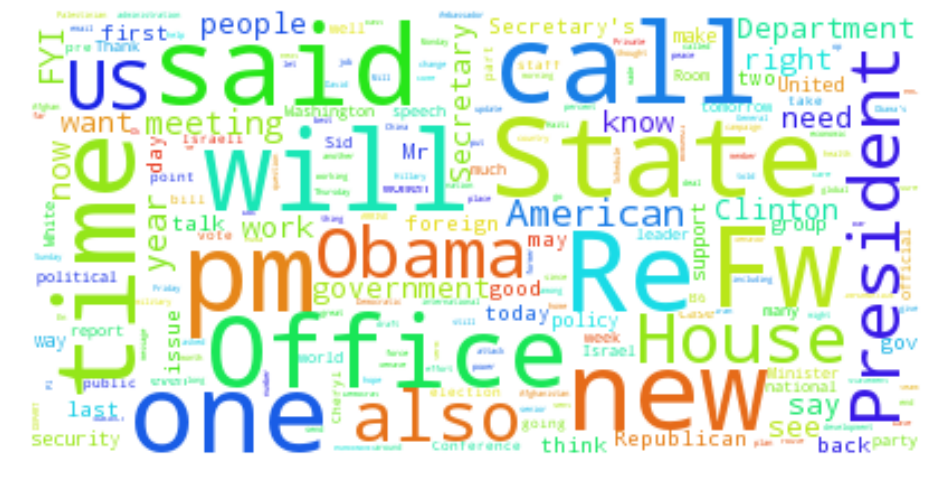

In [7]:
wordcloud = gen_wordcloud(raw_corpus)
plot_wordcloud(wordcloud)

### 1.2 Standard stemming

For this part we will use `ntlk`'s built-in Snowball stemmer and tokenizer, plus a list of custom stopwords.

In [14]:
from nltk.stem.snowball import SnowballStemmer

english_stopwords = nltk.corpus.stopwords.words('english')

local_stopwords = [
    'fyi', 'will', 'call', 'said', 'time', 'want', 'know', 'pm', 'am', 
    'also', 'call', 'know', 'would', 'get', 'time', 'work', 'like', 'today',
    'see', 'morning', 'also', 'back', 'tomorrow', 'meeting', 'think', 'good',
    'want', 'could', 'working', 'well', 'pls', 're', 'fw', 'new', 'thx', 'fwd'
]

stopwords = set(english_stopwords + local_stopwords)

stemmer = SnowballStemmer('english', ignore_stopwords=True)

Let's define a helper function to tokenize and stem some text:

In [15]:
import re

def tokenize_and_stem(text):
    
    # First tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = [token for token in tokens if re.search('^[a-zA-Z]+$', token)]

    # Stem the resulting tokens, filtering out words present in our local stopwords list
    stems = [stemmer.stem(token) for token in filtered_tokens if token not in stopwords]
    
    # Once again, filter out words present in our local stopwords list
    return [stem for stem in stems if stem not in stopwords and len(stem) > 1]

Tokenize the whole corpus:

In [16]:
tokenized = tokenize_and_stem(raw_corpus)

Join the list of tokens by space, to get a single resulting string:

In [17]:
flat_tok = ' '.join(tokenized)

Generate and plot a WordCloud of that resulting string:

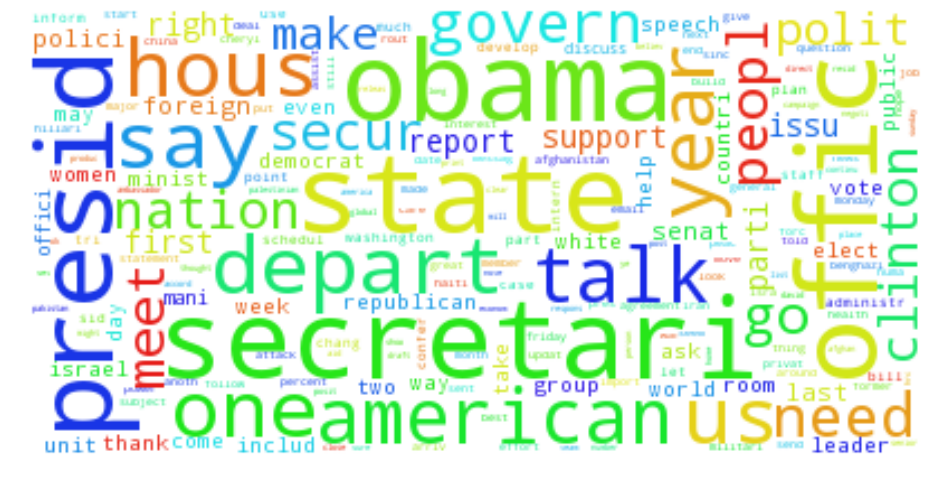

In [18]:
wordcloud_processed = gen_wordcloud(flat_tok)
plot_wordcloud(wordcloud_processed)

It's clear that the latter Wordcloud is both more interesting and more informative than the first one, as it doesn't feature common words, and only focus on stemmed words. For example, it features prominenty the stemmed word `secreatari`, which only appear very small as `Secretary's` in the raw WordCloud.

# 2. Sentiment analysis

* Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (*HINT*: remember that
there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.)
* Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. 
* Aggregate the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level) that summarizes the perception of the different countries.
* Repeat the aggregation + plotting steps using different demo methods from the sentiment analysis module -- can you find substantial differences?

### Extract countries and perform sentiment analysis

Please see [extract_countries_parallel.py](https://github.com/romac/ADAHomeworks/blob/master/05%20-%20Taming%20Text/extract_countries_parallel.py) for the code we used to process the whole corpus of e-mails in parallel and generate the following two pickled data structures:

In [19]:
import pickle

sentiments_data_nocodes = pickle.load(open('countries_sentiments_vader_nocodes.p', 'rb'))
sentiments_data_codes   = pickle.load(open('countries_sentiments_vader_codes.p', 'rb'))

### Aggregate the polarity information of all the emails by country,

In [20]:
def aggregate_by_country(data, threshold):
    res = {}

    for key in data:
        sents = data[key]['sentiments']
        count = data[key]['count']

        if count < threshold:
            continue

        res[key] = {
            'sentiment': sum(sents) / float(len(sents)),
            'count': count
        }

    countries_df = pd.DataFrame.from_dict(res, orient='index')
    countries_df = countries_df.sort_values(by='sentiment', axis=0)
    
    return countries_df

In [21]:
countries_df_nocodes = aggregate_by_country(sentiments_data_nocodes, 25)
countries_df_codes = aggregate_by_country(sentiments_data_codes, 500)

### Plot a histogram that summarizes the perception of the different countries

In [22]:
def plot_countries(countries_df):

    # Credits to Stack Overflow :
    # http://stackoverflow.com/questions/31313606/pyplot-matplotlib-bar-chart-with-fill-color-depending-on-value
    from matplotlib import cm

    plt.figure(figsize=(18, 8), dpi=80)

    # Set up colors : red to green
    y = np.array(countries_df['sentiment'])
    colors = cm.RdYlGn((y / float(max(y))))
    plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
    plt.clf()
    clb = plt.colorbar(plot)
    clb.ax.set_title("Sentiment")

    # Display bar plot : country frequency vs. country name, with color indicating polarity score
    plt.bar(range(countries_df.shape[0]), countries_df['count'], align='center', tick_label=countries_df.index, color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Country")
    plt.ylabel("Frequency")
    plt.show()

#### When using only the country names to match countries in the corpus

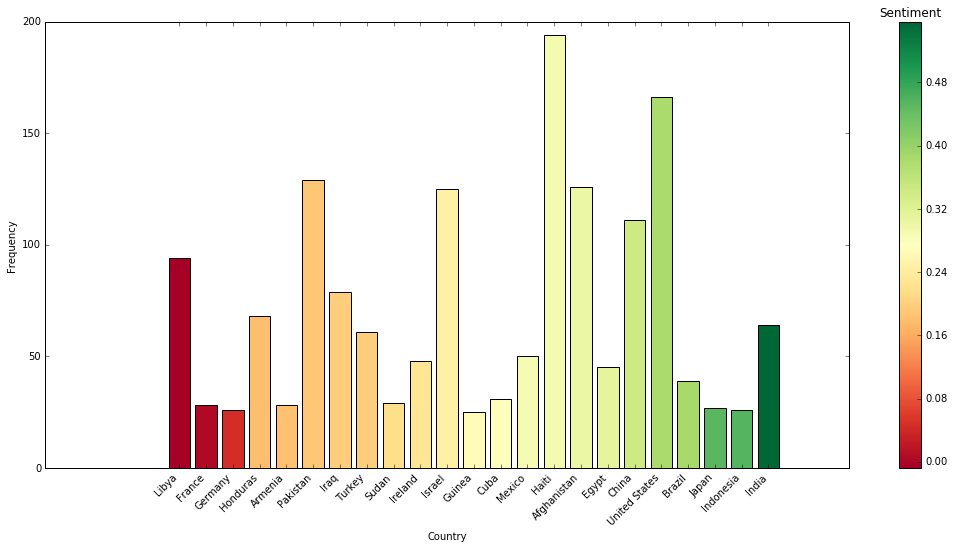

In [23]:
plot_countries(countries_df_nocodes)

#### When using the country names and short codes to match countries in the corpus

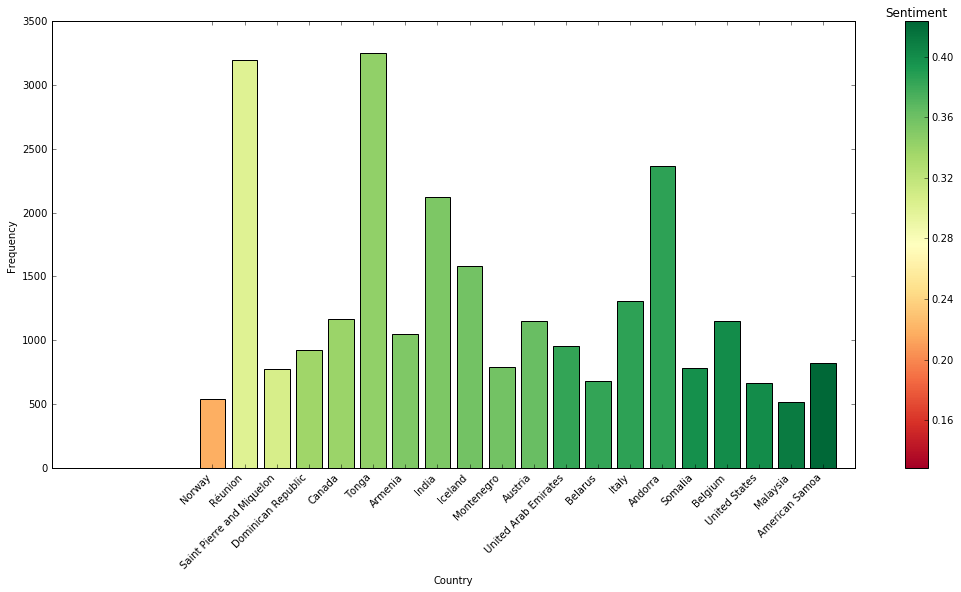

In [24]:
plot_countries(countries_df_codes)

**Note:** We weren't able to get the Liu-Hu sentiment analysis method to run over the whole dataset in a reasonable time, and thus chose to stick with the Vader method which, after some tests over a sample of the data, appears to us to be more accurate. Hence, we chose to try a couple different methods for country extraction: one where we take the countries' names and short codes into account, and one where we only use the short and offical names. The results are quite different, as the number of matched countries when using the shortcodes is much greater. We're not very confident that the results we get are very accurate using the short codes, since it's very unlikely that people would refer to eg. Montenegro or Malaysia by their short codes in an e-mail. We nonetheless chose to keep the latter plot, as a comparison point.

# 3. Topic modelling 
### 3.1 Sci-kit learn version

Using the `models.ldamodel` module from the [gensim library](https://radimrehurek.com/gensim/index.html), run topic
modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which
returns topics that you consider to be meaningful at first sight.

In [205]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from sklearn.externals import joblib

In [206]:
def fit_tfidf(emails):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                       min_df=0.2, stop_words=text.ENGLISH_STOP_WORDS,
                                       use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

    tfidf_matrix = tfidf_vectorizer.fit_transform(emails)
    terms = tfidf_vectorizer.get_feature_names()
    return (terms, tfidf_matrix, tfidf_vectorizer)

In [207]:
def fit_tf(articles):
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                    max_features=1000,
                                    stop_words=text.ENGLISH_STOP_WORDS)
    tf_matrix = tf_vectorizer.fit_transform(articles)
    terms = tf_vectorizer.get_feature_names()
    return (terms, tf_matrix, tf_vectorizer)

In [208]:
def run_lda(tf_matrix, tf_vectorizer):
    lda = LatentDirichletAllocation(n_topics=n_topics,
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(tf_matrix)
    return lda

In [209]:
def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join(['\n + ' + str(topic[i]) + '*' + str(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [210]:
print(type(raw_corpus))

<class 'str'>


In [213]:
tfidf_terms, tfidf_matrix, tfidf_vectorizer = fit_tf(df['ExtractedBodyText'].dropna())

In [214]:
joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf_terms, 'tfidf_terms.pkl')

['tfidf_terms.pkl']

In [215]:
n_topics = 10; n_top_words = 20

In [216]:
lda = run_lda(tfidf_matrix, tfidf_vectorizer)

In [245]:
joblib.dump(lda, 'sklearn_lda_model.pkl')

['sklearn_lda_model.pkl']

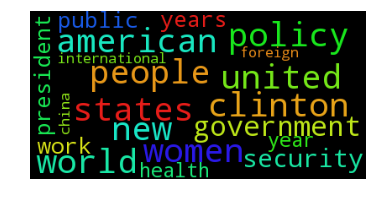

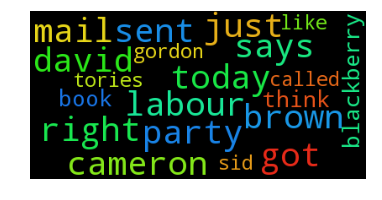

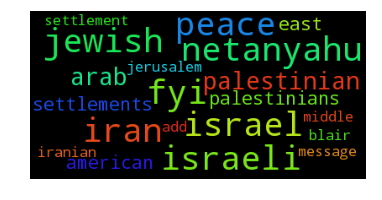

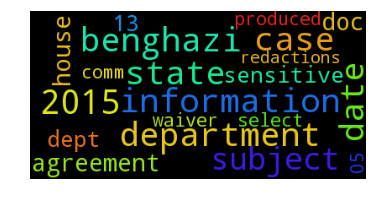

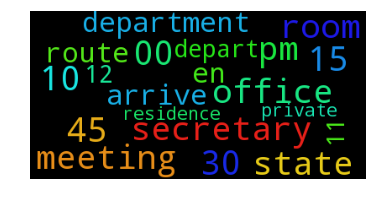

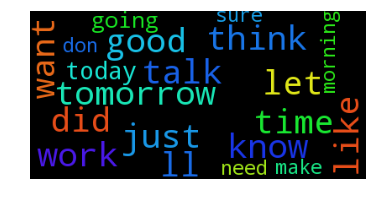

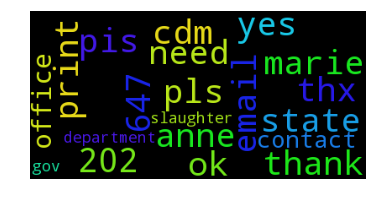

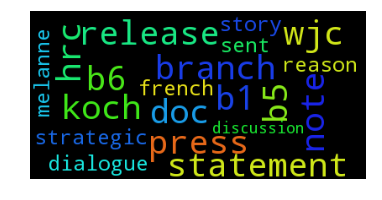

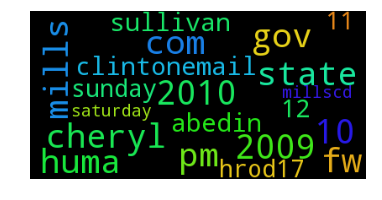

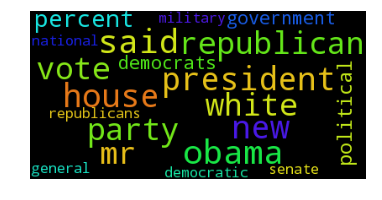

In [251]:
def print_wordclouds(model, feature_names, n_top_words=20):
    for _, topic in enumerate(model.components_):
        freqs = [(str(feature_names[i]), topic[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]
        cloud = WordCloud(max_font_size=40).fit_words(freqs)
        plot_wordcloud(cloud, figsize=None)
        
print_wordclouds(lda, tfidf_terms, n_top_words)

In [244]:
print_top_words(lda, tfidf_terms, n_top_words)

Topic #0:

 + 663.627406061*people 
 + 634.138617357*new 
 + 580.536441513*women 
 + 539.458112339*world 
 + 539.145035206*policy 
 + 480.363011599*clinton 
 + 479.730426644*american 
 + 466.323763076*states 
 + 454.110102085*united 
 + 435.505355589*government 
 + 397.983455485*security 
 + 390.268053346*president 
 + 378.694969315*public 
 + 377.779666318*years 
 + 364.817897428*work 
 + 363.042706822*health 
 + 361.503174064*year 
 + 359.688578626*international 
 + 355.508520023*foreign 
 + 348.203607081*china
Topic #1:

 + 248.297523832*party 
 + 198.295281269*david 
 + 168.970583425*today 
 + 152.5756925*right 
 + 144.503681292*just 
 + 140.695609865*labour 
 + 131.678862705*sent 
 + 126.72965431*brown 
 + 124.499150379*cameron 
 + 124.034863887*says 
 + 123.456339599*got 
 + 115.444641889*mail 
 + 112.416397513*blackberry 
 + 106.65430328*book 
 + 98.5439262036*think 
 + 98.4122343982*gordon 
 + 94.2646923225*called 
 + 86.5358871383*sid 
 + 83.7761727395*tories 
 + 81.1141146516

### 3.2 gensim version

In [32]:
import gensim
import joblib
from gensim import corpora, models

load_from_disk = True

if not load_from_disk:

    texts = []

    mail_df = df[['ExtractedSubject', 'ExtractedBodyText']].dropna()

    for idx, mail in mail_df.iterrows():
        text = str(mail['ExtractedSubject']) + ' ' + str(mail['ExtractedBodyText'])
        tokens = tokenize_and_stem(text)
        texts.append(tokens)

    # Create dictionary
    dictionary = corpora.Dictionary(texts)

    # Bag of Words
    corpus = [dictionary.doc2bow(text) for text in texts]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20)
    
    # joblib.dump(ldamodel, 'gensim_lda_model.pkl')
    
else:
    
    # Load the data we computed in the previous run
    ldamodel = joblib.load('gensim_lda_model.pkl')

In [33]:
topics = ldamodel.show_topics(num_topics=15, num_words=10, formatted=False)
topics

[(0,
  [('go', 0.045722848418049918),
   ('vote', 0.026168991058271293),
   ('point', 0.019600898288890372),
   ('administr', 0.019314754490708876),
   ('letter', 0.018508694746158721),
   ('media', 0.01815453468998323),
   ('editori', 0.017419209935425166),
   ('afghanistan', 0.015657154756580562),
   ('post', 0.013229997133273622),
   ('done', 0.013020095164679944)]),
 (1,
  [('talk', 0.047417275726218275),
   ('first', 0.035027567522819041),
   ('hous', 0.030578659557033799),
   ('diplomaci', 0.026736774565878748),
   ('privat', 0.021933543588800408),
   ('end', 0.019861022728946669),
   ('happi', 0.019186118867052255),
   ('respons', 0.016008717105751944),
   ('america', 0.015376883827912005),
   ('got', 0.014939913438350189)]),
 (2,
  [('meet', 0.038617112130845489),
   ('polit', 0.035632800114676767),
   ('clinton', 0.025580900427979034),
   ('plan', 0.025106546230905736),
   ('ask', 0.024814627545053675),
   ('discuss', 0.023278716451001984),
   ('print', 0.022889018225429571),


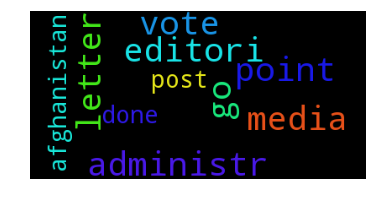

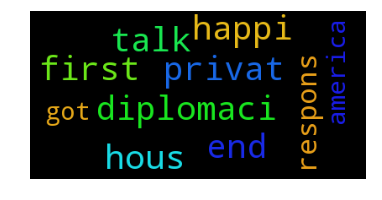

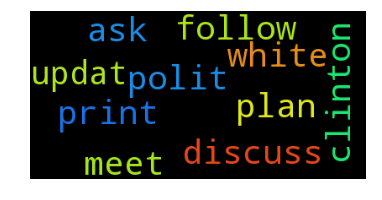

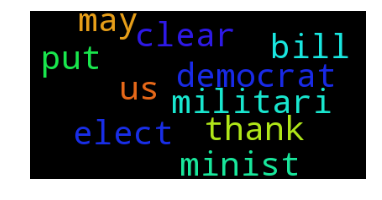

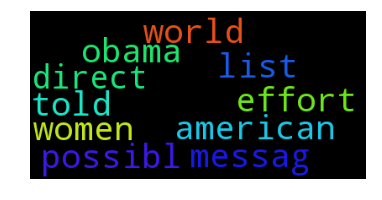

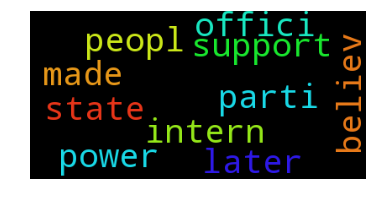

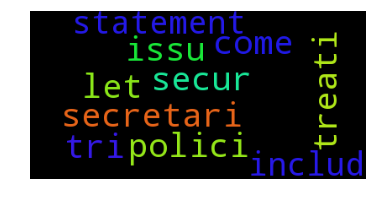

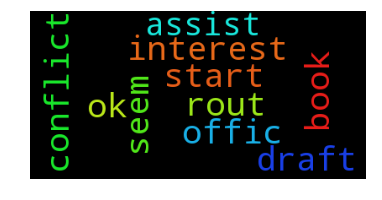

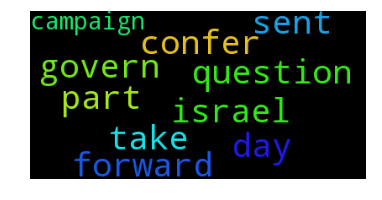

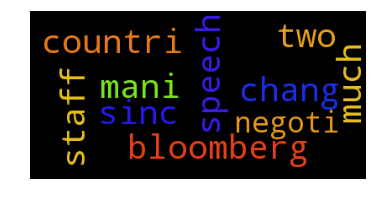

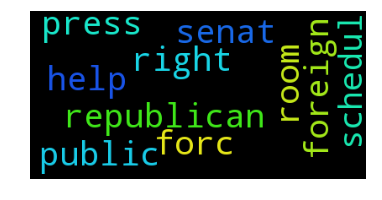

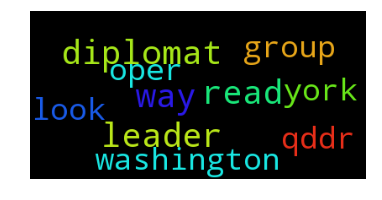

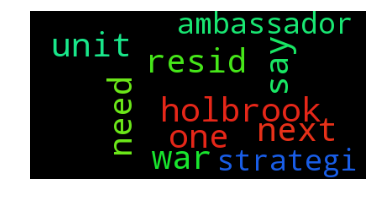

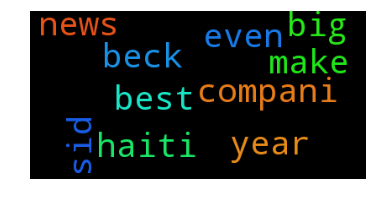

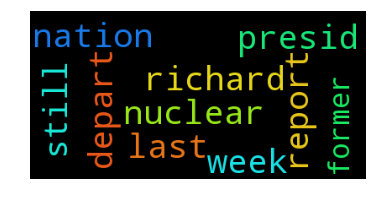

In [30]:
for (_, terms) in topics:
    cloud = WordCloud(max_font_size=40).fit_words(terms)
    plot_wordcloud(cloud, figsize=None)

# 4. (bonus) Communication graph
*BONUS*: build the communication graph (unweighted and undirected) among the different email senders and recipients
using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the 
[community detection module](http://perso.crans.org/aynaud/communities/index.html). Print the most frequent 20 words used
by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
Can you identify clear discussion topics for each community? Discuss briefly the obtained results.

In [36]:
import networkx as nx
import community as cm

In [37]:
subset = df[0:100]

subset.sample()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
44,45,C05739612,PRETTY POWERFUL PIECE ON STANDING UP FOR DIPLO...,H,"Mills, Cheryl D",32.0,2012-09-14T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739612...,F-2015-04841,...,NaN,"Milts, Cheryl 0 <MillsCD@state.gov>",NaN,"Friday, September 14, 2012 5:59 AM",F-2015-04841,C05739612,05/13/2015,RELEASE IN FULL,Fyi,UNCLASSIFIED\nU.S. Department of State\nCase N...
